# Parse file with errors

* Create class DataProcess
    * gets file from given path or local access.log file as a sample
    * using regular expression finds lines containing 'error' in file
    * can check how many lines with errors are in file and returns timedelta
        * shows two types of plots using matplotlib
        * saves files with plots to drive
* Used sqlalchemy to create DB and persist data from DataProcess class
* Used SQL to show all error records
** Used flas to create simple API endpoint and 2 routes to return 
* data as JSON object
* return text - how many records are in DB

#### Import modules for class DataProcess

In [95]:
%matplotlib inline

import re
import os
import calendar
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

#### Sanity check for directory

In [96]:
print(os.getcwd())

/media/sf_SharedFolderDS/code/bootcamp_data_science/Week_02


In [209]:
class DataProcess:
    """DataProcess class gets data from file, parses for lines with error and can visualise in plots"""
    @staticmethod
    def get_file_contents(fpath="./access.log"):
        """Returns data contents. Defaults to syslog"""
        return open(fpath)
        
    @staticmethod
    def print_file_contents(file=""):
        """Prints out file contents. Default value to syslog"""
        if len(file) < 1:
            file = "./access.log"
        fh = DataProcess.get_file_contents(file)
        for line in fh:
            print(line)
    @staticmethod
    def print_lines_with(pattern=r"error"):
        """Prints out lines with errors. Default value to error"""
        fh = DataProcess.get_file_contents()
        for line in fh:
            if not re.findall(pattern, line, re.IGNORECASE): continue
            print(line)
    @staticmethod        
    def count_errors():
        """Counts errors in file"""
        fh = DataProcess.get_file_contents()
        errors_cnt = 0
        pattern=r"error"
        for line in fh:
            if not re.findall(pattern, line, re.IGNORECASE): continue
            errors_cnt += 1
        err_arr = DataProcess.get_error_data()
        time_delta = err_arr[-1][0] - err_arr[0][0]
        return errors_cnt, time_delta
    @staticmethod        
    def get_error_data():
        """Returns error array with time, name and part of description"""
        fh = DataProcess.get_file_contents()
        months_dict = dict((v,k) for k,v in enumerate(calendar.month_abbr))
        pattern=r"error"
        error_array = []
        for line in fh:
            if not re.findall(pattern, line, re.IGNORECASE): continue
            err_type = line.split(' ')[6]
            err_name = line.split(' ')[0]
            month = line.split(' ')[3].split('/')[1]
            day = line.split(' ')[3].split('/')[0][1:]
            year = line.split(' ')[3].split('/')[2].split(':')[0]
            hours = line.split(' ')[3].split('/')[2].split(':')[1]
            minutes = line.split(' ')[3].split('/')[2].split(':')[2]
            seconds = line.split(' ')[3].split('/')[2].split(':')[3]
            t = datetime(int(year), months_dict[month], int(day), int(hours), int(minutes), int(seconds), 345, tzinfo=timezone.utc)
            error_array.append([t, err_type, err_name])
        
        return error_array
    @staticmethod
    def plot_errors():
        """Simple plot to display how many errors in time were thrown"""
        err_arr = DataProcess.get_error_data() 
        dates = np.array([x[0] for x in err_arr])
        values = np.array([1 for x in err_arr])
        plt.plot_date(dates, values)
        plt.title('Error Log')
        plt.xlabel("Date")
        plt.ylabel("Error")
        plt.savefig("Error_Log.png")
        plt.show()
    @staticmethod
    def plot_err_hist():
        """Plots histogram with errors"""
        err_arr = DataProcess.get_error_data()
        dates = np.array([mdates.date2num(x[0]) for x in err_arr])
        values = np.array([1 for x in err_arr])
        fig, ax = plt.subplots()
        ax.hist(dates, bins=44, color='lightblue')
        locator = mdates.AutoDateLocator()
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
        fig.autofmt_xdate()
        plt.title('Error Log')
        plt.xlabel("Date")
        plt.ylabel("Error Count")
        plt.savefig("Error_Log_Hist.png")
        plt.show()        

## Sample Usage of DataProcess class

Prints out lines containting errors from file

In [211]:
DataProcess.print_lines_with()

40.77.167.66 - - [13/Dec/2015:12:05:25 +0100] "GET /apache-log/error.log.44.gz HTTP/1.1" 404 232 "-" "Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm)" "-"

157.55.39.8 - - [13/Dec/2015:16:14:58 +0100] "GET /apache-log/error.log.55.gz HTTP/1.1" 404 232 "-" "Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm)" "-"

188.143.232.11 - - [13/Dec/2015:18:43:22 +0100] "GET /apache-log/error.log HTTP/1.1" 200 1514 "-" "Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; SV1)" "-"

40.77.167.94 - - [16/Dec/2015:21:00:26 +0100] "GET /apache-log/error.log.20.gz HTTP/1.1" 404 232 "-" "Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm)" "-"

180.76.15.10 - - [17/Dec/2015:11:26:35 +0100] "GET /apache-log/error.log HTTP/1.1" 200 10998 "-" "Mozilla/5.0 (compatible; Baiduspider/2.0; +http://www.baidu.com/search/spider.html)" "-"

180.76.15.16 - - [20/Dec/2015:08:25:52 +0100] "GET /apache-log/error.log HTTP/1.1" 200 20047 "-" "Mozilla/5.0 (c

Count errors and returns timedelta object

In [212]:
DataProcess.count_errors()

(44, datetime.timedelta(44, 23060))

Two types of error visualisation. Graphs saved as file to same location as notebook

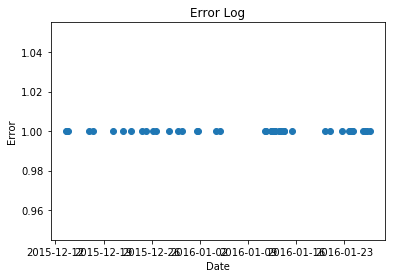

In [213]:
DataProcess.plot_errors()

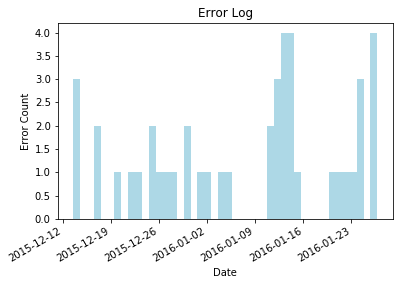

In [210]:
DataProcess.plot_err_hist()

## Create DB to store errors

Implementation based on https://www.pythoncentral.io/introductory-tutorial-python-sqlalchemy/

import modules needed for DB manipulation and sqlalchemy

In [217]:
import os
import sys
from sqlalchemy import Column, ForeignKey, String, DateTime, Integer
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
 
Base = declarative_base()

Create class describing DB table

In [218]:
class ErrorLog(Base):
    __tablename__ = 'errorlog'
    id = Column(Integer, primary_key=True)
    error_type = Column(String(250))
    error_name = Column(String(250))
    error_date = Column(DateTime, default=datetime.utcnow)

Create sqlite engine

In [219]:
engine = create_engine('sqlite:///error_log.db')

Create schema from class

In [220]:
Base.metadata.create_all(engine)

In [221]:
Base.metadata.bind = engine
DBSession = sessionmaker(bind=engine)

Create session object

In [222]:
session = DBSession()

Create one error as sanity check

In [223]:
new_error = ErrorLog(error_name='New error')
session.add(new_error)
session.commit()

Display all rows of ErrorLog table

In [224]:
session.query(ErrorLog).all()

select first record display object and then print error_name field value

In [225]:
some_error = session.query(ErrorLog).first()

In [226]:
print(some_error)

In [227]:
print(some_error.error_name)

 FuMain


Delete record with name New error

In [231]:
session.query(ErrorLog).filter_by(error_name='New error').delete()

0

Delete all rows from DB before persisting data from file

In [230]:
session.query(ErrorLog).delete()

50

## Persist all errors in DB

In [232]:
for record in DataProcess.get_error_data():
    new_error = ErrorLog(error_name=record[2], error_type=record[1], error_date=record[0])
    session.add(new_error)
session.commit()

In [233]:
for err in session.query(ErrorLog).all():
    print(f'{err.error_date}: {err.error_type} - {err.error_name}')

2015-12-13 12:05:25.000345: /apache-log/error.log.44.gz - 40.77.167.66
2015-12-13 16:14:58.000345: /apache-log/error.log.55.gz - 157.55.39.8
2015-12-13 18:43:22.000345: /apache-log/error.log - 188.143.232.11
2015-12-16 21:00:26.000345: /apache-log/error.log.20.gz - 40.77.167.94
2015-12-17 11:26:35.000345: /apache-log/error.log - 180.76.15.10
2015-12-20 08:25:52.000345: /apache-log/error.log - 180.76.15.16
2015-12-21 19:28:46.000345: /apache-log/error.log.47.gz - 157.55.39.92
2015-12-22 22:13:49.000345: /apache-log/error.log.88.gz - 207.46.13.161
2015-12-24 14:17:10.000345: /apache-log/error.log.84.gz - 207.46.13.70
2015-12-25 03:36:04.000345: /apache-log/error.log.89.gz - 157.55.39.169
2015-12-26 04:09:40.000345: /apache-log/error.log - 66.249.66.22
2015-12-26 16:30:54.000345: /apache-log/error.log.41.gz - 40.77.167.0
2015-12-28 13:58:35.000345: /apache-log/error.log.66.gz - 157.55.39.245
2015-12-29 19:48:49.000345: /apache-log/error.log - 2.137.210.106
2015-12-30 11:16:25.000345: /apa

## Raw SQL to DB

In [234]:
from sqlalchemy import text
sql = text('select * from ErrorLog')
result = session.execute(sql)

In [235]:
for row in result:
    print(row)

(1, '/apache-log/error.log.44.gz', '40.77.167.66', '2015-12-13 12:05:25.000345')
(2, '/apache-log/error.log.55.gz', '157.55.39.8', '2015-12-13 16:14:58.000345')
(3, '/apache-log/error.log', '188.143.232.11', '2015-12-13 18:43:22.000345')
(4, '/apache-log/error.log.20.gz', '40.77.167.94', '2015-12-16 21:00:26.000345')
(5, '/apache-log/error.log', '180.76.15.10', '2015-12-17 11:26:35.000345')
(6, '/apache-log/error.log', '180.76.15.16', '2015-12-20 08:25:52.000345')
(7, '/apache-log/error.log.47.gz', '157.55.39.92', '2015-12-21 19:28:46.000345')
(8, '/apache-log/error.log.88.gz', '207.46.13.161', '2015-12-22 22:13:49.000345')
(9, '/apache-log/error.log.84.gz', '207.46.13.70', '2015-12-24 14:17:10.000345')
(10, '/apache-log/error.log.89.gz', '157.55.39.169', '2015-12-25 03:36:04.000345')
(11, '/apache-log/error.log', '66.249.66.22', '2015-12-26 04:09:40.000345')
(12, '/apache-log/error.log.41.gz', '40.77.167.0', '2015-12-26 16:30:54.000345')
(13, '/apache-log/error.log.66.gz', '157.55.39.